In [1]:
import sys
sys.path.append('..')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib as mpl
import seaborn as sns

from scipy import stats

import visualizor

In [2]:
df = pd.read_csv('../final_data.csv')

C:\Users\marcu\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3418: DtypeWarning: Columns (19,24) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
df['dt'] = pd.to_datetime(df.publishedAt)
df['comment_date'] = df.dt.dt.date

In [4]:
df['release_date_us_dt'] = pd.to_datetime(df.release_date_us)
df['upper_date_lim'] = df.release_date_us_dt + pd.Timedelta(30, "d")
df['lower_date_lim'] = df.release_date_us_dt - pd.Timedelta(30, "d")
df = df[(df.comment_date <= df.upper_date_lim) & (df.comment_date >= df.lower_date_lim)]

In [5]:
df['comment_idx'] = (pd.to_datetime(df.comment_date) - df.release_date_us_dt)
df['comment_idx'] = df.comment_idx.astype(str).str[:-5].astype(int)

In [6]:
ratings = df.groupby(['videoId', 'videoTitle', 'primaryTitle', 'averageRating']).agg(
    num_comments=('commentId', 'count')
).reset_index()
lo, hi = ratings.averageRating.quantile([.33, .66])

(array([241.,  37.,  13.,   9.,   0.,   1.,   1.,   0.,   2.,   0.,   3.,
          2.,   1.,   1.,   0.,   0.,   0.,   0.,   1.]),
 array([    0.        ,  1284.84210526,  2569.68421053,  3854.52631579,
         5139.36842105,  6424.21052632,  7709.05263158,  8993.89473684,
        10278.73684211, 11563.57894737, 12848.42105263, 14133.26315789,
        15418.10526316, 16702.94736842, 17987.78947368, 19272.63157895,
        20557.47368421, 21842.31578947, 23127.15789474, 24412.        ]),
 <BarContainer object of 19 artists>)

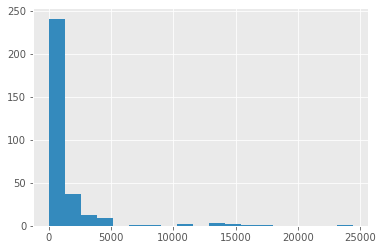

In [7]:
fig, ax = plt.subplots()

bins = np.linspace(0, ratings.num_comments.max(), 20)
ax.hist(ratings.num_comments, bins=bins)


<ipython-input-8-d82ad293ed1d>:12: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(0, y.max())


(0.6034201826036534, 24412.0)

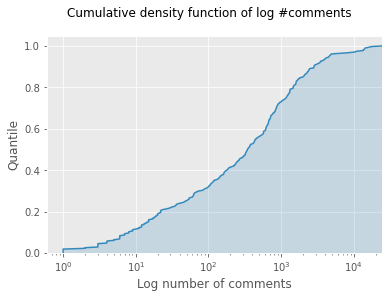

In [8]:
x = np.linspace(0, 1, 1000)
y = ratings.num_comments.quantile(x)
fig, ax = plt.subplots()
ax.plot(y, x)
ax.fill_between(y, x, alpha=.2)
ax.set_xscale('log')
fig.suptitle('Cumulative density function of log #comments')
ax.set_xlabel('Log number of comments')
ax.set_ylabel('Quantile')

ax.set_ylim(0, 1.05)
ax.set_xlim(0, y.max())


<ipython-input-120-ee6956637b32>:28: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax2.set_xlim(0, y.max())


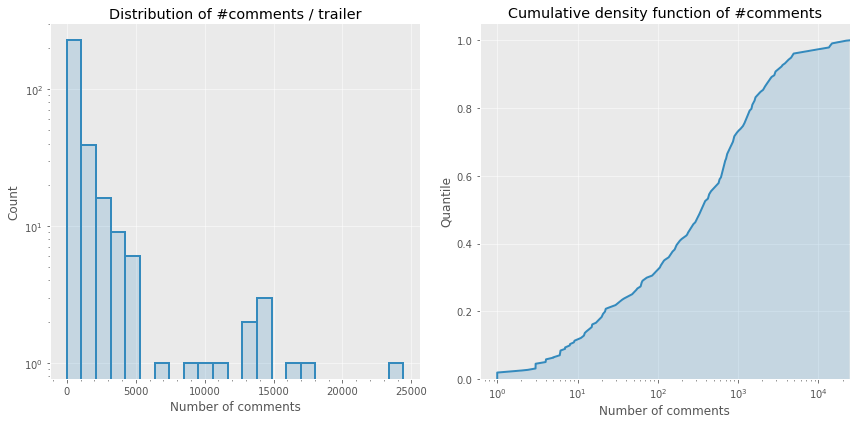

In [120]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))


bins = np.linspace(1, ratings.num_comments.max(), 24)
ax1.hist(ratings.num_comments, bins=bins, edgecolor='#348ABD', fill=False, linewidth=2)
ax1.hist(ratings.num_comments, bins=bins, alpha=.2, color='#348ABD')
ax1.set_yscale('log')

ax1.xaxis.set_minor_locator(MultipleLocator(1000))

ax1.set_title('Distribution of #comments / trailer')
ax1.set_xlabel('Number of comments')
ax1.set_ylabel('Count')


x = np.linspace(0, 1, 1000)
y = ratings.num_comments.quantile(x)
ax2.plot(y, x)
ax2.fill_between(y, x, alpha=.2)
ax2.set_xscale('log')
ax2.set_title('Cumulative density function of #comments')
ax2.set_xlabel('Number of comments')
ax2.set_ylabel('Quantile')



ax2.set_ylim(0, 1.05)
ax2.set_xlim(0, y.max())

plt.tight_layout()

In [11]:
fig.savefig('comment_dist.svg')

In [7]:
mask_lo = df.averageRating <= lo
mask_mi = (df.averageRating > lo) & (df.averageRating <= hi)
mask_hi = df.averageRating > hi

In [175]:
df_lo = df[mask_lo]
df_mi = df[mask_mi]
df_hi = df[mask_hi]

agg_lo = df_lo.groupby(['primaryTitle', 'comment_idx']).agg(
    sentiment=('sentiment_predicted_score', 'mean'),
    comment_count=('commentId', 'count')
).reset_index()

agg_mi = df_mi.groupby(['primaryTitle', 'comment_idx']).agg(
    sentiment=('sentiment_predicted_score', 'mean'),
    comment_count=('commentId', 'count')
).reset_index()

agg_hi = df_hi.groupby(['primaryTitle', 'comment_idx']).agg(
    sentiment=('sentiment_predicted_score', 'mean'),
    comment_count=('commentId', 'count')
).reset_index()

In [176]:
agg_lo = agg_lo.groupby('comment_idx').agg(
    sentiment=('sentiment', 'median'),
    comment_count_mean=('comment_count', 'median')
).reset_index()

agg_mi = agg_mi.groupby('comment_idx').agg(
    sentiment=('sentiment', 'median'),
    comment_count_mean=('comment_count', 'median')
).reset_index()

agg_hi = agg_hi.groupby('comment_idx').agg(
    sentiment=('sentiment', 'median'),
    comment_count_mean=('comment_count', 'median')
).reset_index()

In [177]:
window = 7
trend_lo = agg_lo.rolling(window=window, center=True).mean().sentiment
trend_mi = agg_mi.rolling(window=window, center=True).mean().sentiment
trend_hi = agg_hi.rolling(window=window, center=True).mean().sentiment

In [112]:
style = plt.style.library['ggplot']
style['axes.facecolor'] = '#eaeaea'
plt.style.use(style)

In [244]:
hi_params = {
    'color': '#E24A33',
    'label': 'Over average rating'
}

mi_params = {
    'color': '#348ABD',
    'label': 'Average rating'
}

lo_params = {
    'color': '#988ED5',
    'label': 'Under average rating'
}

annot_params = {
    'color': '#777777',
    'linestyle': '--'
}

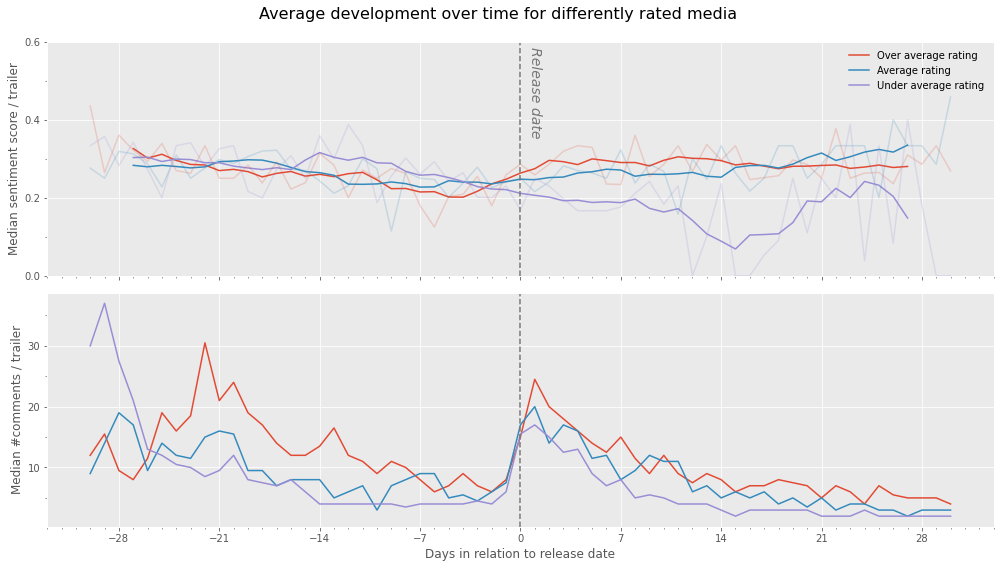

In [251]:
plt.style.use('ggplot')
fig, axes = plt.subplots(2, figsize=(14,8))

fig.suptitle('Average development over time for differently rated media ', fontsize=16)

# sentiment over time
ax = axes[0]

ax.plot(agg_hi.comment_idx, trend_hi, **hi_params)
ax.plot(agg_mi.comment_idx, trend_mi, **mi_params)
ax.plot(agg_lo.comment_idx, trend_lo, **lo_params)

ax.legend(frameon=False)

ax.plot(agg_hi.comment_idx, agg_hi.sentiment, alpha=.2, **hi_params)
ax.plot(agg_mi.comment_idx, agg_mi.sentiment, alpha=.2, **mi_params)
ax.plot(agg_lo.comment_idx, agg_lo.sentiment, alpha=.2, **lo_params)

ax.xaxis.set_major_locator(MultipleLocator(7))
ax.xaxis.set_minor_locator(MultipleLocator(1))

ax.yaxis.set_major_locator(MultipleLocator(.2))
ax.yaxis.set_minor_locator(MultipleLocator(.1))
ax.set_xticklabels([])

ax.set_ylim(0, .6)

# ax.axhline(y=0, color='k', alpha=.5)
ax.axvline(x=0, **annot_params)
ax.text(0.5, .36, 'Release date', color=annot_params['color'], fontsize=14, fontstyle='italic', rotation=-90)

ax.set_ylabel('Median sentiment score / trailer')





# count of comments over time
ax = axes[1]

ax.plot(agg_hi.comment_idx, agg_hi.comment_count_mean, **hi_params)
ax.plot(agg_mi.comment_idx, agg_mi.comment_count_mean, **mi_params)
ax.plot(agg_lo.comment_idx, agg_lo.comment_count_mean, **lo_params)

# ax.set_yscale('log')
ax.axvline(x=0, **annot_params)

ax.xaxis.set_major_locator(MultipleLocator(7))
ax.xaxis.set_minor_locator(MultipleLocator(1))

ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(5))

ax.set_xlabel('Days in relation to release date')
ax.set_ylabel('Median #comments / trailer')


plt.tight_layout()

In [252]:
fig.savefig('dev-time-rating.svg')

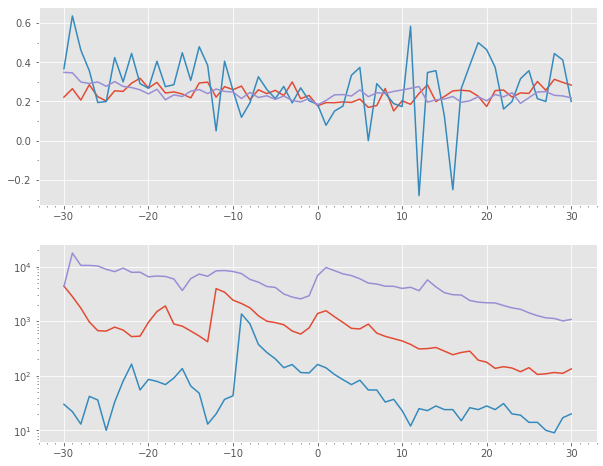

In [47]:
fig, axes = plt.subplots(2, figsize=(10,8))

networks = df.network.unique()


for network in networks:
    mask = df.network == network
    agg = df[mask].groupby('comment_idx').agg(
        sentiment=('sentiment_predicted_score', 'mean'),
        comment_count=('commentId', 'count')
    ).reset_index()
    
    ax = axes[0]
    ax.plot(agg.comment_idx, agg.sentiment)
    
    ax = axes[1]
    ax.plot(agg.comment_idx, agg.comment_count)


ax = axes[0]
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(1))

ax.yaxis.set_major_locator(MultipleLocator(.2))
ax.yaxis.set_minor_locator(MultipleLocator(.1))

ax = axes[1]
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.set_yscale('log')

In [132]:
df

,Unnamed: 0,channelId,network,videoId,videoTitle,publishTime,commentId,textOriginal,likeCount,publishedAt,...,numVotes,release_date_us,sentiment_label,sentiment_score,dt,comment_date,release_date_us_dt,upper_date_lim,lower_date_lim,comment_idx
0,0,UCx-KWLTKlB83hDI6UKECtJQ,hbo,DotnJ7tTA34,House of the Dragon | Official Trailer | HBO Max,2022-07-20T17:00:16Z,UgytElLIz55Py5wweE94AaABAg,Watch the first episode of #HouseoftheDragon f...,245,2022-09-02T15:20:05Z,...,264406,21 August 2022,NaN,NaN,2022-09-02 15:20:05+00:00,2022-09-02,2022-08-21,2022-09-20,2022-07-22,12
330,330,UCx-KWLTKlB83hDI6UKECtJQ,hbo,DotnJ7tTA34,House of the Dragon | Official Trailer | HBO Max,2022-07-20T17:00:16Z,Ugy23hd70Lz5lpNFT1d4AaABAg,You did it HBO!\n\nI'm so proud of you.,1,2022-09-20T22:03:16Z,...,264406,21 August 2022,NaN,NaN,2022-09-20 22:03:16+00:00,2022-09-20,2022-08-21,2022-09-20,2022-07-22,30
331,331,UCx-KWLTKlB83hDI6UKECtJQ,hbo,DotnJ7tTA34,House of the Dragon | Official Trailer | HBO Max,2022-07-20T17:00:16Z,UgynxG_5bVKmMgEw3d54AaABAg,Trailer hits different after watching first 5 ...,3,2022-09-20T20:45:27Z,...,264406,21 August 2022,NaN,NaN,2022-09-20 20:45:27+00:00,2022-09-20,2022-08-21,2022-09-20,2022-07-22,30
332,332,UCx-KWLTKlB83hDI6UKECtJQ,hbo,DotnJ7tTA34,House of the Dragon | Official Trailer | HBO Max,2022-07-20T17:00:16Z,UgzFDcLk8S2io3XSC9R4AaABAg,Please Hindi dubbed Karo,0,2022-09-20T17:09:39Z,...,264406,21 August 2022,NaN,NaN,2022-09-20 17:09:39+00:00,2022-09-20,2022-08-21,2022-09-20,2022-07-22,30
333,333,UCx-KWLTKlB83hDI6UKECtJQ,hbo,DotnJ7tTA34,House of the Dragon | Official Trailer | HBO Max,2022-07-20T17:00:16Z,UgzWCi7kYFSBC1KoXcZ4AaABAg,I just wish there was not brutal violence in s...,0,2022-09-20T16:24:01Z,...,264406,21 August 2022,NaN,NaN,2022-09-20 16:24:01+00:00,2022-09-20,2022-08-21,2022-09-20,2022-07-22,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
731351,731351,UCWOA1ZGywLbqmigxE4Qlvuw,netflix,vRunUkdkK8s,ATHENA directed by Romain Gavras | Official Tr...,2022-08-24T15:10:00Z,UgyjaUHjY2-B_I1ybF54AaABAg,Looks great,17,2022-08-24T15:14:14Z,...,12837,23 September 2022,NaN,NaN,2022-08-24 15:14:14+00:00,2022-08-24,2022-09-23,2022-10-23,2022-08-24,-30
731352,731352,UCWOA1ZGywLbqmigxE4Qlvuw,netflix,vRunUkdkK8s,ATHENA directed by Romain Gavras | Official Tr...,2022-08-24T15:10:00Z,Ugw8yIe3zMjlJw9dtLt4AaABAg,this movie will be a whole experience,47,2022-08-24T15:13:25Z,...,12837,23 September 2022,NaN,NaN,2022-08-24 15:13:25+00:00,2022-08-24,2022-09-23,2022-10-23,2022-08-24,-30
731353,731353,UCWOA1ZGywLbqmigxE4Qlvuw,netflix,vRunUkdkK8s,ATHENA directed by Romain Gavras | Official Tr...,2022-08-24T15:10:00Z,UgzYhqpN1ZJzoWNEwhF4AaABAg,Movie of the year,13,2022-08-24T15:11:39Z,...,12837,23 September 2022,NaN,NaN,2022-08-24 15:11:39+00:00,2022-08-24,2022-09-23,2022-10-23,2022-08-24,-30
731354,731354,UCWOA1ZGywLbqmigxE4Qlvuw,netflix,vRunUkdkK8s,ATHENA directed by Romain Gavras | Official Tr...,2022-08-24T15:10:00Z,Ugwgkd2Yt1pdz4kzl-l4AaABAg,Cringe af.,28,2022-08-24T15:10:57Z,...,12837,23 September 2022,NaN,NaN,2022-08-24 15:10:57+00:00,2022-08-24,2022-09-23,2022-10-23,2022-08-24,-30


In [8]:
mean_scores = df[df.comment_idx < 0].groupby(['videoId', 'primaryTitle']).agg(
    sentiment=('sentiment_predicted_score', 'mean'),
    imdb_score=('averageRating', 'first'),
    network=('network', 'first'),
    num_comments=('commentId', 'count'),
    comments_since=('comment_idx', 'min'),
    titleType=('titleType', 'first')
).reset_index()

In [9]:
mask = (mean_scores.comments_since <= 10) & (mean_scores.num_comments >= 100)
X = mean_scores[mask]

In [10]:
X

,videoId,primaryTitle,sentiment,imdb_score,network,num_comments,comments_since,titleType
0,-JtwROpSVWc,The Knight Before Christmas,0.381663,5.6,netflix,469,-14,movie
1,-NOp5ROn1HE,The Dirt,0.211687,7.0,netflix,1814,-27,movie
2,-Pwxr307O4w,Rescued by Ruby,0.437979,7.2,netflix,653,-23,movie
3,-aZBIpZY_Fw,Inside Job,0.334409,7.6,netflix,1549,-27,tvSeries
4,-gQ_I-tVk9E,Ten Percent,0.389706,6.9,amazon,136,-28,tvSeries
...,...,...,...,...,...,...,...,...
285,xDc_iartATY,The Bastard Son & The Devil Himself,0.166311,7.6,netflix,469,-15,tvSeries
286,xFE8ASwxmpA,Our Flag Means Death,0.422764,7.8,hbo,123,-15,tvSeries
288,xyYaUflEwK0,The Grand Tour Presents: Carnage A Trois,0.429864,7.9,amazon,221,-23,tvEpisode
293,zRpHyvuJ__A,Wahl Street,0.136000,6.1,hbo,375,-17,tvSeries


(-1.0, 1.0)

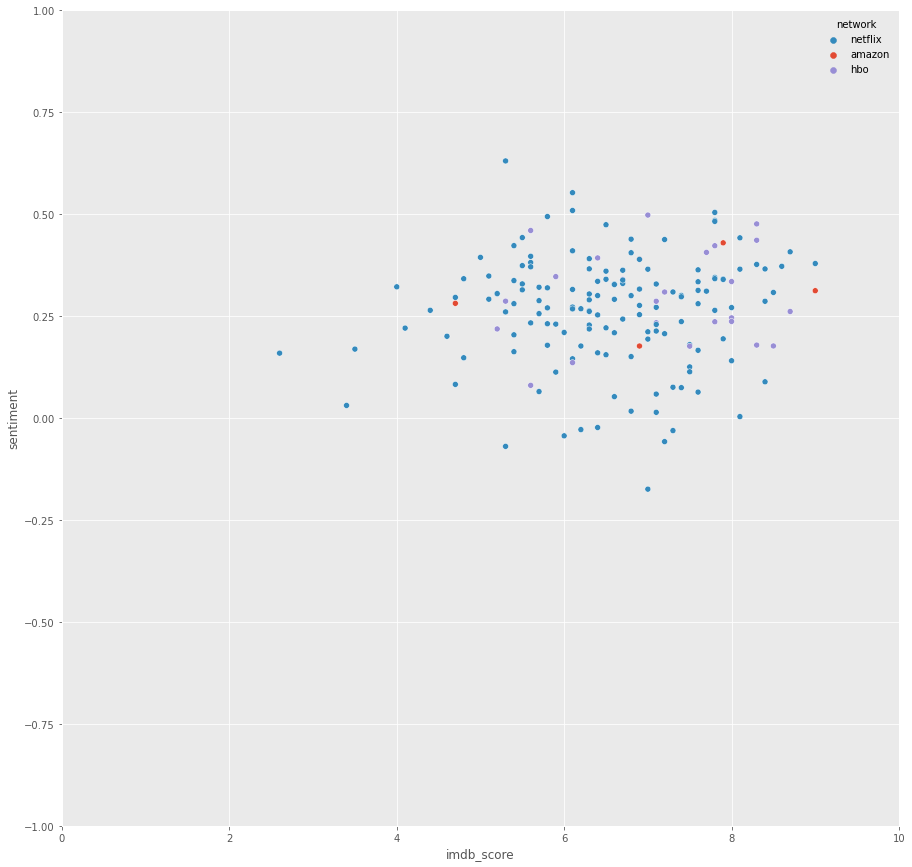

In [12]:
fig, ax = plt.subplots(figsize=(15,15))
sns.scatterplot(data=X, x='imdb_score', y='sentiment', hue='network', ax=ax)

ax.set_xlim(0, 10)
ax.set_ylim(-1, 1)

In [11]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(X.sentiment.to_numpy().reshape(-1, 1), X.imdb_score.to_numpy().reshape(-1, 1))

LinearRegression()

Text(0.5, 1.0, 'Relation between sentiment on trailers and critical reception of product')

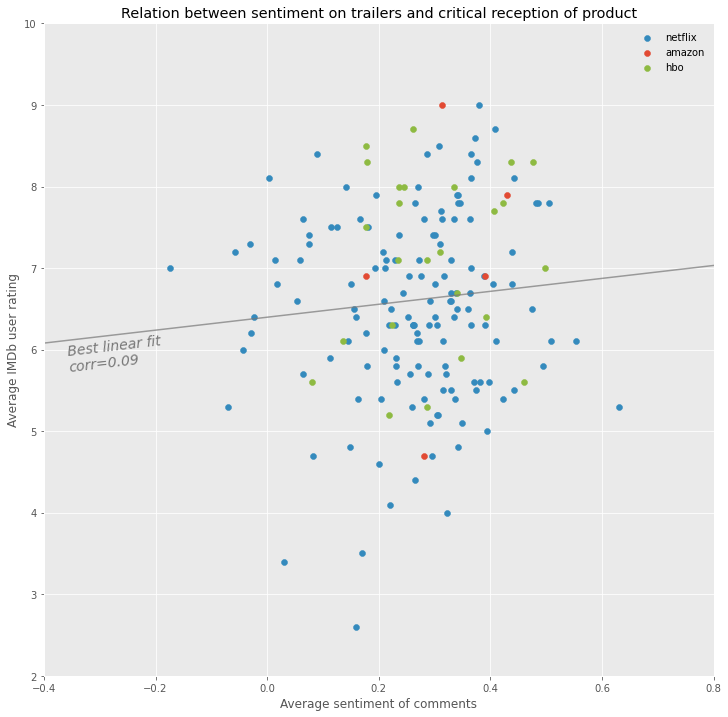

In [81]:
fig, ax = plt.subplots(figsize=(12,12))

for network in X.network.unique():
    mask = X.network == network
    ax.scatter(X[mask].sentiment, X[mask].imdb_score, label=network)

ax.legend()

ax.set_ylim(2, 10)
ax.set_xlim(-.4, .8)
asdf = np.linspace(-1, 1, 10000)

ax.plot(asdf, reg.predict(asdf.reshape(-1,1)).flatten(), alpha=.7, color='#777777')
ax.text(-.36, 6.2, 'Best linear fit\ncorr=0.09', rotation=6.6, fontsize=14, fontstyle='italic', color='#777777', va='top')

ax.set_xlabel('Average sentiment of comments')
ax.set_ylabel('Average IMDb user rating')
ax.set_title('Relation between sentiment on trailers and critical reception of movie/show')

In [193]:
reg.score(X.sentiment.to_numpy().reshape(-1, 1), X.imdb_score.to_numpy().reshape(-1, 1))

0.008118110551725177

In [196]:
from scipy.stats import pearsonr

pearsonr(X.sentiment, X.imdb_score)

(0.09010055799896621, 0.2370676651380158)

In [76]:
X.corr()

,sentiment,imdb_score,num_comments,comments_since
sentiment,1.000000,0.090101,-0.027247,-0.050516
imdb_score,0.090101,1.000000,0.105203,0.022450
num_comments,-0.027247,0.105203,1.000000,-0.021305
comments_since,-0.050516,0.022450,-0.021305,1.000000


In [132]:
mpl.rcParams

RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': True,
          'axes.edgecolor': 'white',
          'axes.facecolor': '#eaeaea',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.f

In [157]:
annot_params = {
    'color': '#777777',
    'linestyle': '--'
}

plot_dict = {
    True: {
        'color': '#348ABD',
        'label': 'Above average rating'
    },
    
    False: {
        'color': '#E24A33',
        'label': 'Below average rating'
    }
}

window_size=4

157
152


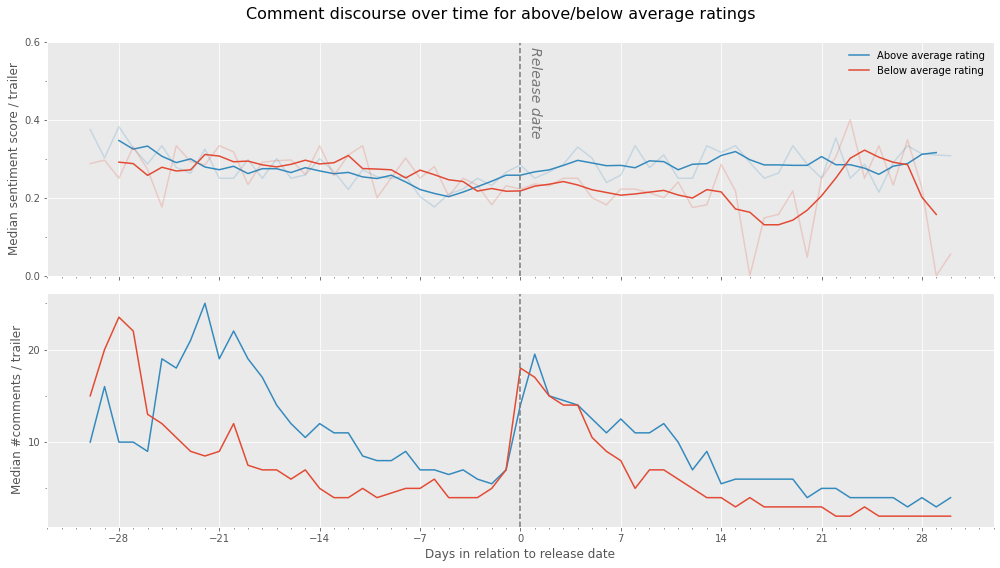

In [236]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(14,8))
fig.suptitle('Comment discourse over time for above/below average ratings', fontsize=16)

X = df

# asdf = X.primaryTitle.value_counts().index[X.primaryTitle.value_counts() >= 500]
# X = X[X.primaryTitle.isin(asdf)]

threshold = X[['tconst', 'averageRating']].drop_duplicates().averageRating.median()

mask = X.averageRating >= threshold
X['threshold'] = mask

# X = X[(X.averageRating <= threshold) | (X.averageRating >= threshold)]

for condition in X.threshold.unique():
    mask = X.threshold == condition
    print(X[mask].primaryTitle.nunique())
    Xagg = X[mask].groupby(['comment_idx', 'videoId', 'primaryTitle']).agg(
        sentiment=('sentiment_predicted_score', 'mean'),
        numComments=('commentId', 'count')
    ).reset_index()
    
    Xagg = Xagg.groupby('comment_idx').agg(
        sentiment=('sentiment', 'median'),
        numComments=('numComments', 'median')
    ).reset_index()
    
    trend = Xagg.rolling(window=window_size, center=True).mean().sentiment
   
    trend = ax1.plot(Xagg.comment_idx, trend, **plot_dict[condition])
    ax1.plot(Xagg.comment_idx, Xagg.sentiment, alpha=.2)
    ax2.plot(Xagg.comment_idx, Xagg.numComments)


ax1.set_ylim(0, .6)

ax1.axvline(x=0, **annot_params)
ax1.text(0.5, .36, 'Release date', color=annot_params['color'], fontsize=14, fontstyle='italic', rotation=-90)

ax1.set_ylabel('Median sentiment score / trailer')

ax1.xaxis.set_major_locator(MultipleLocator(7))
ax1.xaxis.set_minor_locator(MultipleLocator(1))

ax1.yaxis.set_major_locator(MultipleLocator(.2))
ax1.yaxis.set_minor_locator(MultipleLocator(.1))
ax1.set_xticklabels([])

    
ax2.axvline(x=0, **annot_params)

ax2.xaxis.set_major_locator(MultipleLocator(7))
ax2.xaxis.set_minor_locator(MultipleLocator(1))

ax2.yaxis.set_major_locator(MultipleLocator(10))
ax2.yaxis.set_minor_locator(MultipleLocator(5))

ax2.set_xlabel('Days in relation to release date')
ax2.set_ylabel('Median #comments / trailer')

ax1.legend()

plt.tight_layout()

In [207]:
fig.savefig('discourse_time.svg')